# Emulating the LHC Output

In [43]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import cf_xarray
from scipy import stats

## Read inputs (parameter scaling factors)

In [3]:
x = xr.open_dataarray('./processed_data/lhc220926.nc')

In [4]:
x

<xarray.DataArray (param: 32, ens: 500)>
array([[0.778311, 0.319329, 0.876772, ..., 0.185969, 0.26213 , 0.422114],
       [0.358026, 0.548803, 0.210794, ..., 0.996422, 0.91228 , 0.839212],
       [0.255021, 0.630191, 0.662125, ..., 0.422209, 0.533934, 0.144342],
       ...,
       [0.393617, 0.041084, 0.819746, ..., 0.242643, 0.71595 , 0.21237 ],
       [0.078962, 0.275619, 0.840143, ..., 0.842275, 0.353015, 0.36344 ],
       [0.684588, 0.878455, 0.951915, ..., 0.731144, 0.358052, 0.15671 ]])
Coordinates:
  * param    (param) object 'FUN_fracfixers' 'KCN' ... 'tpuse_sf' 'wc2wjb0'
  * ens      (ens) object 'LHC0001' 'LHC0002' 'LHC0003' ... 'LHC0499' 'LHC0500'

In [5]:
x.shape

(32, 500)

In [6]:
xt = x.transpose()
xt.shape

(500, 32)

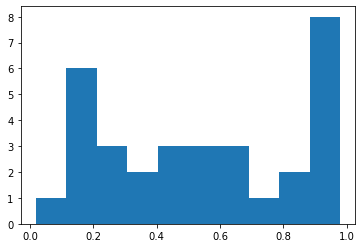

In [7]:
plt.hist(xt[100]);

In [10]:
y = xr.open_dataarray('./processed_data/fourvars_gmean_amean_2005-2014.nc')

In [11]:
y

<xarray.DataArray (var: 4, ens: 500)>
array([[2.488403e+00, 2.094031e+00, 3.763566e+00, ..., 1.735267e+00,
        1.792857e+00, 1.977623e+00],
       [3.832554e-05, 3.836190e-05, 4.283603e-05, ..., 2.776507e-05,
        2.816218e-05, 3.492068e-05],
       [3.061194e+01, 3.192346e+01, 2.667541e+01, ..., 2.939185e+01,
        3.349612e+01, 3.071059e+01],
       [4.678233e+01, 4.272905e+01, 4.868657e+01, ..., 3.957385e+01,
        3.842887e+01, 3.911139e+01]])
Coordinates:
  * var      (var) object 'TLAI' 'GPP' 'SOILWATER_10CM' 'EFLX_LH_TOT'
  * ens      (ens) object 'LHC0001' 'LHC0002' 'LHC0003' ... 'LHC0499' 'LHC0500'

In [13]:
y.shape

(4, 500)

In [27]:
yt = y.transpose()
yt.shape

(500, 4)

In [28]:
y_scale = (yt - yt.mean(dim='ens'))/yt.std(dim='ens')

In [29]:
y_scale.shape

(500, 4)

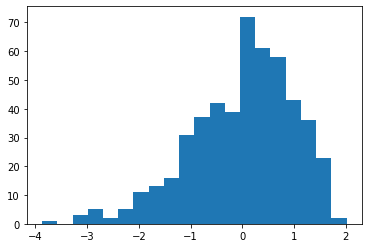

In [30]:
# sanity check rescaling
plt.hist(y_scale.sel(var='EFLX_LH_TOT'), bins=20);

### Define years

In [61]:
yr0 = 2005
yr1 = 2014

In [111]:
# Random seed for reproducibility
#np.random.seed(9)

### Gaussian Process Regression
See: ``gp_regression.ipynb``

See: https://esem.readthedocs.io/en/latest/emulation.html#gaussian-processes-emulation

In [24]:
## gaussian process regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Instantiate a Gaussian Process model
# key factors include setting up kernel, chosing alpha
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.1,normalize_y=True)

In [31]:
# Separate training/testing data: 80/20 split
# Randomly using sklearn
from sklearn.model_selection import train_test_split
x_train_GP,x_test_GP,y_train_GP,y_test_GP = train_test_split(xt,y_scale,test_size=0.2,train_size=0.8)

In [32]:
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x_train_GP, y_train_GP);

In [33]:
gp.kernel_

2.46**2 * RBF(length_scale=4.04)

In [34]:
# Testing data for prediction
y_pred, sigma = gp.predict(x_test_GP, return_std=True) # note that y_pred & sigma don't have coordinate labels (numpy array)

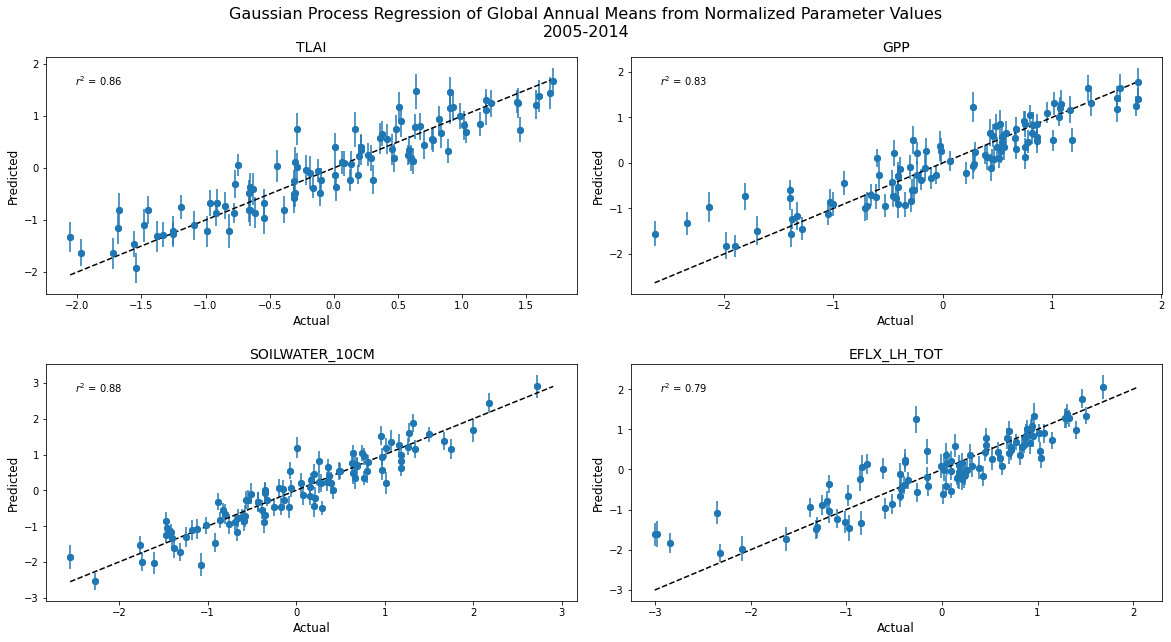

In [62]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(y_test_GP.sel(var=v),y_pred[:,i])
    ax[i].set_xlabel('Actual', fontsize=12)
    ax[i].set_ylabel('Predicted', fontsize=12)
    # standard deviation as error bars
    ax[i].errorbar(y_test_GP.sel(var=v),y_pred[:,i], yerr=sigma[:,i], fmt="o")

    # bounds for one-to-one line
    bounds = (np.amin([y_test_GP.sel(var=v),y_pred[:,i]]),np.amax([y_test_GP.sel(var=v),y_pred[:,i]]))

    # one-to-one line
    ax[i].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--');

    # r^2 calculation and display
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_GP.sel(var=v),y_pred[:,i])
    pltstr = "$r^2$ = %.2g" % r_value**2
    ax[i].text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)

    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Gaussian Process Regression of Global Annual Means from Normalized Parameter Values\n2005-2014', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_GPR_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

#### Emulate variables vs. kmax with all other params set at 0.5
First using test data

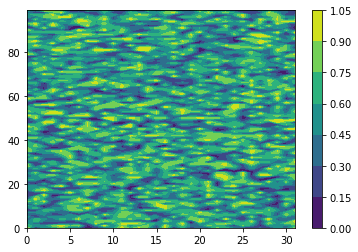

In [64]:
plt.contourf(x_test_GP)
plt.colorbar();

In [65]:
x_test_GP_kmax = x_test_GP.where(x_test_GP.param=='kmax', other=0.5)

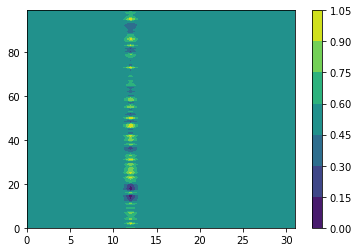

In [66]:
plt.contourf(x_test_GP_kmax)
plt.colorbar();

In [67]:
# Testing data for prediction
y_pred_kmax, sigma = gp.predict(x_test_GP_kmax, return_std=True)

In [70]:
sigma.shape

(100, 4)

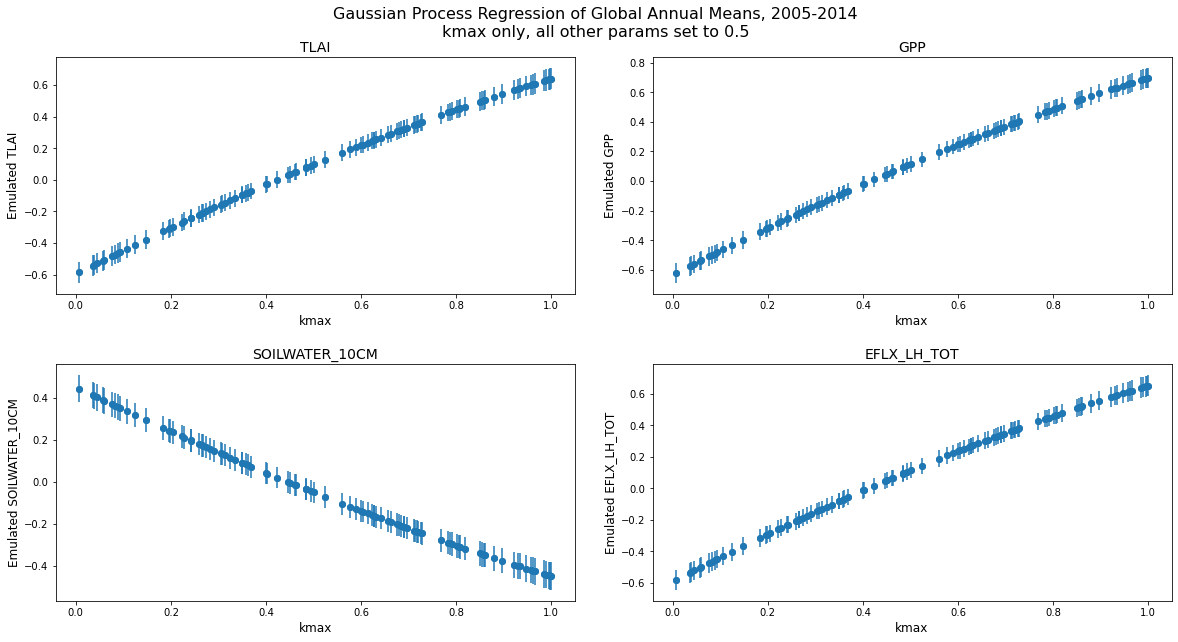

In [74]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(x_test_GP.sel(param='kmax'),y_pred_kmax[:,i])
    ax[i].set_xlabel('kmax', fontsize=12)
    ax[i].set_ylabel('Emulated '+str(v), fontsize=12)
    # standard deviation as error bars
    ax[i].errorbar(x_test_GP.sel(param='kmax'),y_pred_kmax[:,i], yerr=sigma[:,i], fmt="o")
    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Gaussian Process Regression of Global Annual Means, 2005-2014\nkmax only, all other params set to 0.5', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_GPR_kmax_testdata_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

Next using newly generated values (out of sample)

In [75]:
nsamp = 1000
x_oos = np.random.rand(nsamp,xt.shape[1])

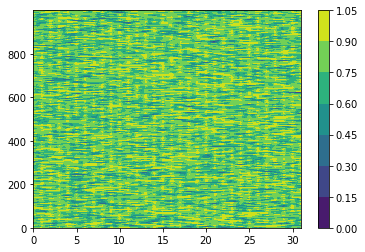

In [76]:
plt.contourf(x_oos)
plt.colorbar();

In [80]:
# label dimensions to enable parameter indexing
x_oos_da = xr.DataArray(x_oos,dims=('ens','param'),coords=dict(param=x.param))

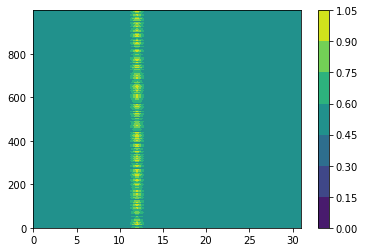

In [81]:
x_oos_kmax = x_oos_da.where(x_oos_da.param=='kmax', other=0.5)
plt.contourf(x_oos_kmax)
plt.colorbar();

In [82]:
y_pred_kmax_oos, sigma_oos = gp.predict(x_oos_kmax, return_std=True)

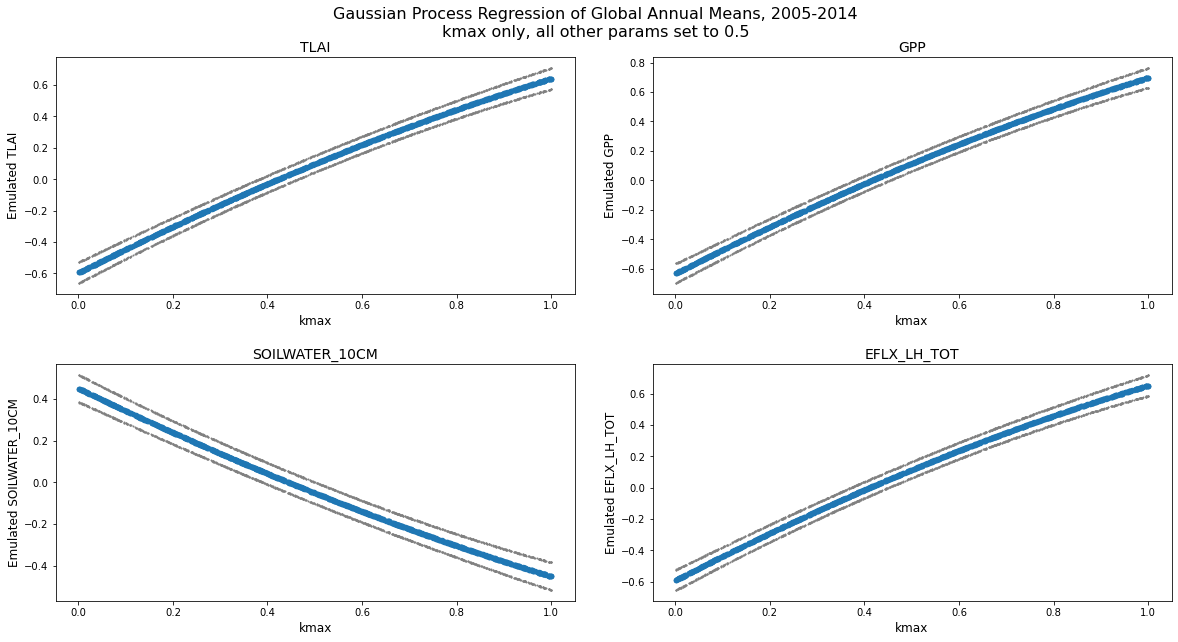

In [87]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(x_oos_da.sel(param='kmax'),y_pred_kmax_oos[:,i], s=20)
    ax[i].set_xlabel('kmax', fontsize=12)
    ax[i].set_ylabel('Emulated '+str(v), fontsize=12)
    # standard deviation as error bars
    #ax[i].errorbar(x_oos_da.sel(param='kmax'),y_pred_kmax_oos[:,i], yerr=sigma_oos[:,i], fmt="o")
    # standard deviation as points
    ax[i].scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos[:,i]-sigma_oos[:,i], s=1, c='grey')
    ax[i].scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos[:,i]+sigma_oos[:,i], s=1, c='grey')
    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Gaussian Process Regression of Global Annual Means, 2005-2014\nkmax only, all other params set to 0.5', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_GPR_kmax_oos_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

### Neural Network

In [88]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import keras.backend as K

Using TensorFlow backend.
/glade/work/kdagon/miniconda/envs/ppe-py-ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/glade/work/kdagon/miniconda/envs/ppe-py-ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/glade/work/kdagon/miniconda/envs/ppe-py-ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [135]:
inputdata=xt
outputdata=y_scale

In [136]:
outputdata.shape

(500, 4)

In [137]:
# Separate training/testing/validation data: 60/20/20 split
xi,x_test,yi,y_test = train_test_split(inputdata,outputdata,test_size=0.2,train_size=0.8)
x_train,x_val,y_train,y_val = train_test_split(xi,yi,test_size=0.25,train_size=0.75)

In [138]:
# Create 2-layer simple model
model = Sequential()

# specify input_dim as number of parameters, not number of simulations
# test 10 nodes in first hidden layer
# l2 norm regularizer
model.add(Dense(10, input_dim=inputdata.shape[1], activation='relu', kernel_regularizer=l2(.001)))

# second layer with hyperbolic tangent activation
# test 5 nodes in second hidden layer
model.add(Dense(5, activation='tanh', kernel_regularizer=l2(.001)))

# output layer with linear activation
model.add(Dense(outputdata.shape[1]))
#model.add(Dense(nmodes)) # for multiple outputs (e.g., GPP and LHF)

In [139]:
# Define model metrics
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

In [140]:
# Compile model with RMSprop optimization

# define learning rate
lr = 0.005
#lr = 0.01

#opt_dense = RMSprop(lr=0.005, rho=0.9, epsilon=1e-07, decay=0.0)
opt_dense = RMSprop(lr=lr)
model.compile(opt_dense, "mse", metrics=[mean_sq_err])

In [141]:
# Fit the model w/ EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=1, patience=50, verbose=1, mode='min')
results = model.fit(x_train, y_train, epochs=500, batch_size=30, callbacks=[es], verbose=0, validation_data=(x_test,y_test))

# Fit the model w/o EarlyStopping
#results = model.fit(x_train, y_train, epochs=500, batch_size=30, verbose=0, validation_data=(x_test,y_test))

Epoch 00051: early stopping


In [142]:
print("Training Mean Error:", results.history['mean_sq_err'][-1])
print("Validation Mean Error:", results.history['val_mean_sq_err'][-1])

Training Mean Error: 0.20357394
Validation Mean Error: 0.25205859541893005


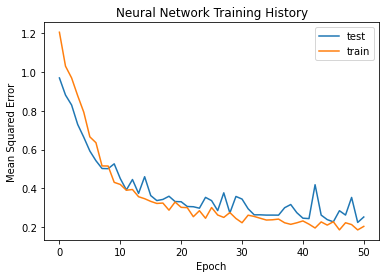

In [143]:
# Plot training history by epoch
plt.plot(results.epoch, results.history['val_mean_sq_err'], label='test')
plt.plot(results.epoch, results.history['mean_sq_err'], label='train')
#plt.xticks(results.epoch)
plt.legend()
#plt.hlines(y=0,xmin=0,xmax=15)
#plt.hlines(y=0,xmin=0,xmax=40)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.title('Neural Network Training History');

In [146]:
# Make predictions - using validation set
model_preds = model.predict(x_val)

In [147]:
model_preds.shape

(100, 4)

In [148]:
# model metric for predictions
def mse_preds(y_true,y_pred):
    return np.mean((y_true-y_pred)**2)

In [149]:
# calculate model mean error with predictions
model_me = mse_preds(y_val, model_preds)
print("Prediction Mean Error: ", model_me.values)

Prediction Mean Error:  0.2781822919237688


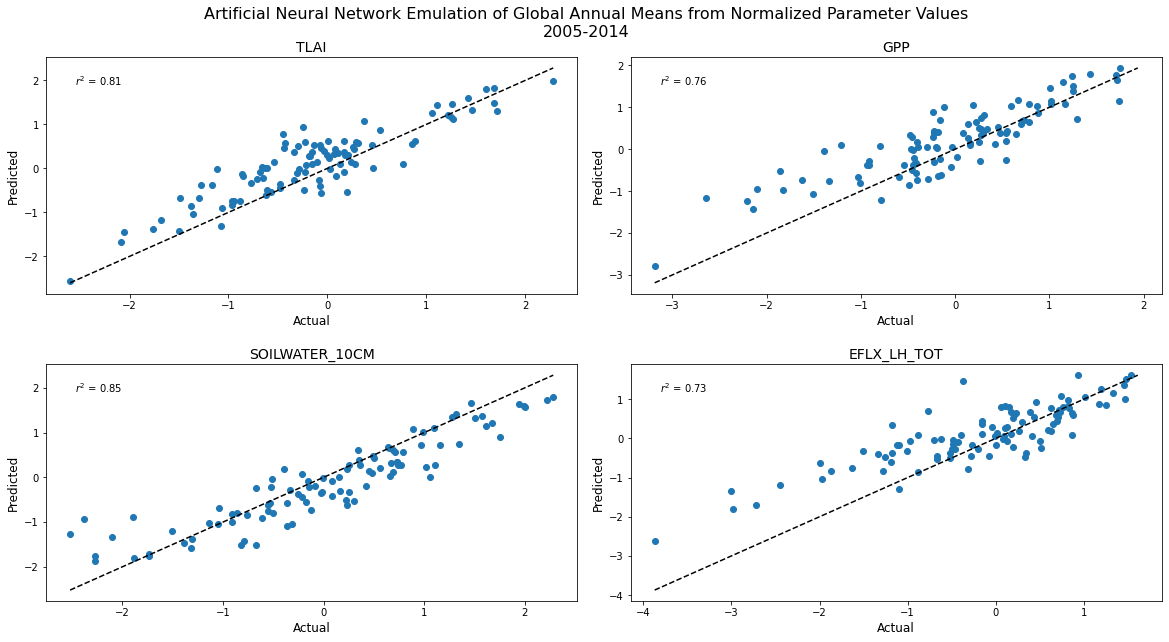

In [157]:
# plot actual vs. predicted
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(y_val.sel(var=v), model_preds[:,i])
    ax[i].set_xlabel('Actual', fontsize=12)
    ax[i].set_ylabel('Predicted', fontsize=12)
    ax[i].set_title(str(v), fontsize=14)
    
    # bounds for one-to-one line
    bounds = (np.amin([y_val.sel(var=v),model_preds[:,i]]),np.amax([y_val.sel(var=v),model_preds[:,i]]))
    
    # one-to-one line
    ax[i].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--')
    
    # linear regression of actual vs predicted
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_val[:,i], model_preds[:,i])
    
    # r^2 value
    pltstr = "$r^2$ = %.2g" % r_value**2
    plt.text(0.1, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
    
fig.suptitle('Artificial Neural Network Emulation of Global Annual Means from Normalized Parameter Values\n2005-2014', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_NN_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

#### Emulate GPP vs. kmax with all other params set at 0.5
First using validation data

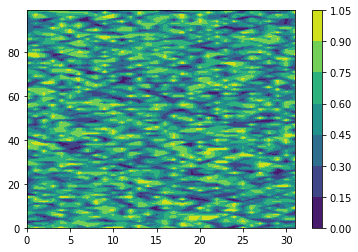

In [158]:
plt.contourf(x_val)
plt.colorbar();

In [159]:
x_val_kmax = x_val.where(x_val.param=='kmax', other=0.5)

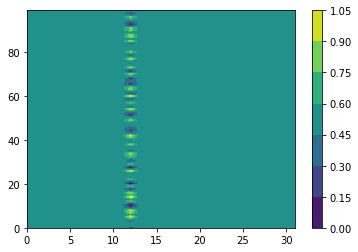

In [160]:
plt.contourf(x_val_kmax)
plt.colorbar();

In [161]:
# Validation data for prediction
model_preds_kmax = model.predict(x_val_kmax)

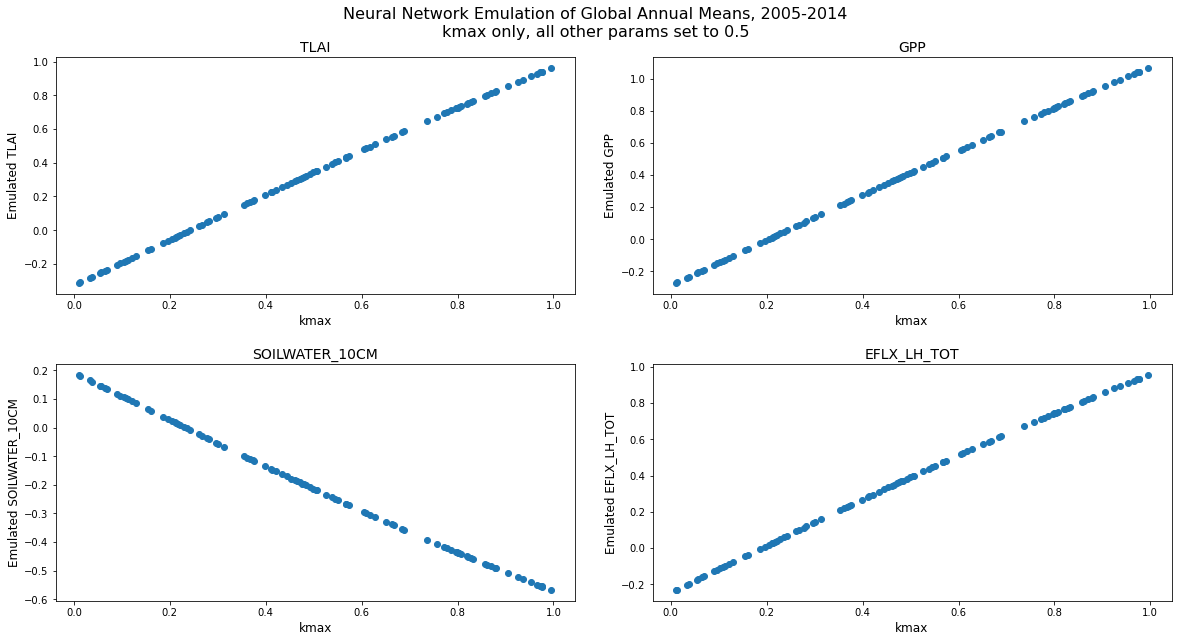

In [163]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(x_val.sel(param='kmax'),model_preds_kmax[:,i])
    ax[i].set_xlabel('kmax', fontsize=12)
    ax[i].set_ylabel('Emulated '+str(v), fontsize=12)
    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Neural Network Emulation of Global Annual Means, 2005-2014\nkmax only, all other params set to 0.5', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_NN_kmax_testdata_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

Next using newly generated values (out of sample)

In [164]:
model_preds_kmax_oos = model.predict(x_oos_kmax)

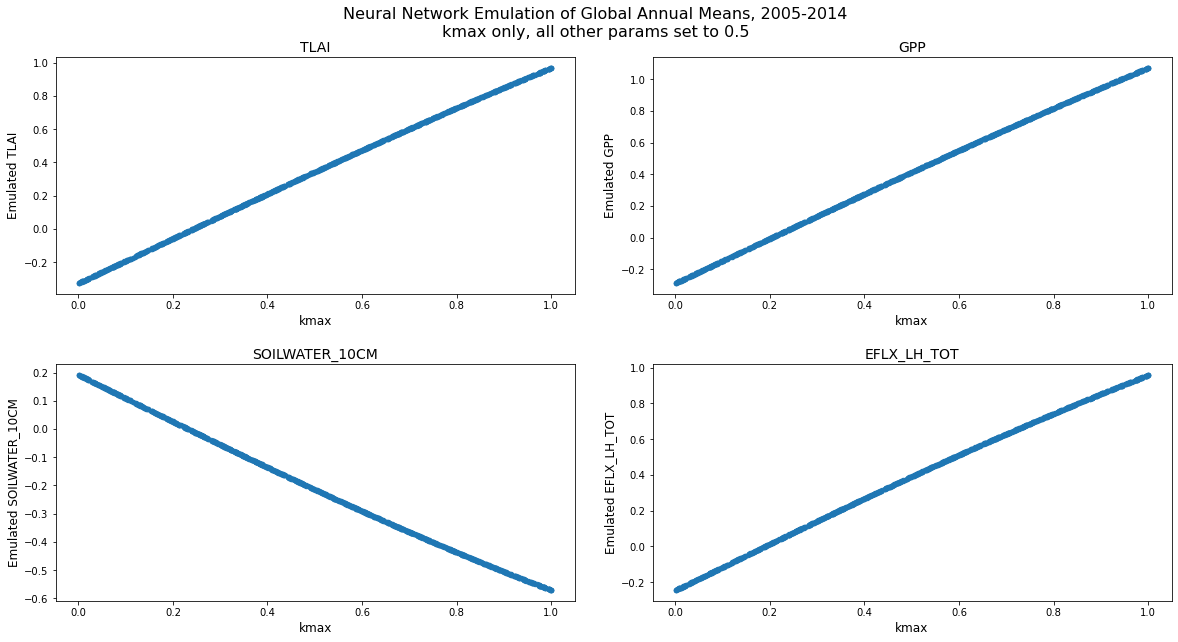

In [166]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(x_oos_da.sel(param='kmax'),model_preds_kmax_oos[:,i], s=20)
    ax[i].set_xlabel('kmax', fontsize=12)
    ax[i].set_ylabel('Emulated '+str(v), fontsize=12)
    ax[i].set_title(str(v), fontsize=14)
    
fig.suptitle('Neural Network Emulation of Global Annual Means, 2005-2014\nkmax only, all other params set to 0.5', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_NN_kmax_oos_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

### Compare response curves

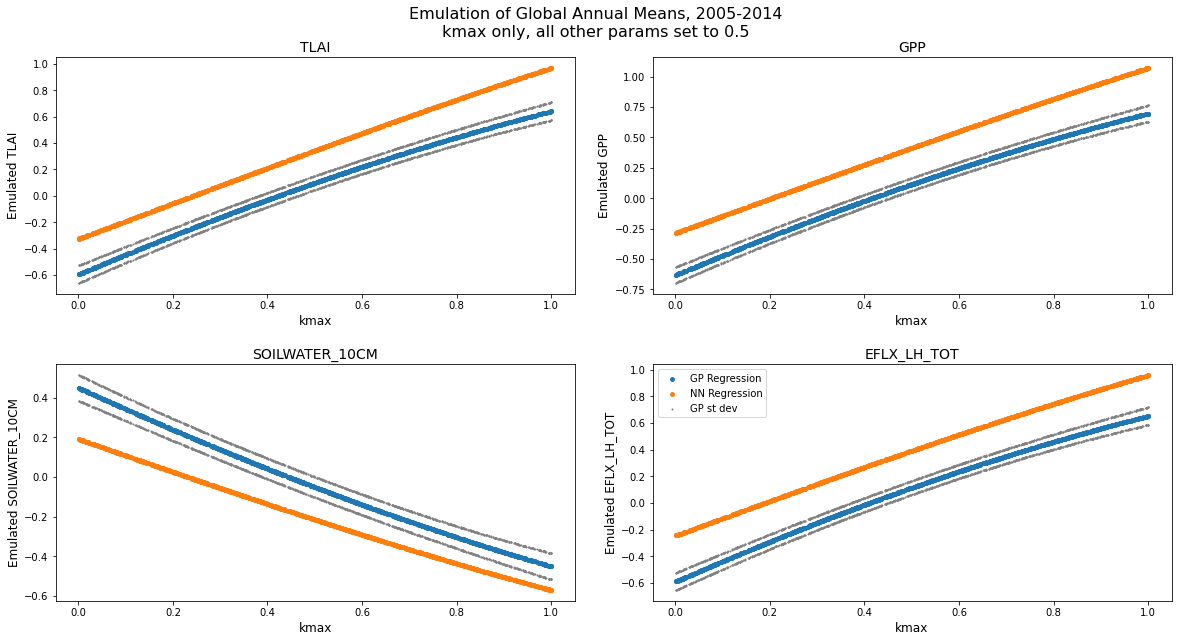

In [169]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = axs.ravel()

for i,v in enumerate(y['var'].values):
    ax[i].scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos[:,i], label='GP Regression', s=15)
    ax[i].scatter(x_oos_da.sel(param='kmax'), model_preds_kmax_oos[:,i], label='NN Regression', s=15)
    ax[i].set_xlabel('kmax', fontsize=12)
    ax[i].set_ylabel('Emulated '+str(v), fontsize=12)
    ax[i].scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos[:,i]-sigma_oos[:,i], s=1, c='grey', label='GP st dev')
    ax[i].scatter(x_oos_da.sel(param='kmax'), y_pred_kmax_oos[:,i]+sigma_oos[:,i], s=1, c='grey')
    ax[i].set_title(str(v), fontsize=14)

plt.legend()

fig.suptitle('Emulation of Global Annual Means, 2005-2014\nkmax only, all other params set to 0.5', y=0.95, fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.3);
#plt.savefig('../figs/lhc/fourvars_GM_AM_GPR_NN_kmax_oos_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')